In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from stochax import OrnsteinUhlenbeck

<Axes: xlabel='Timestamp'>

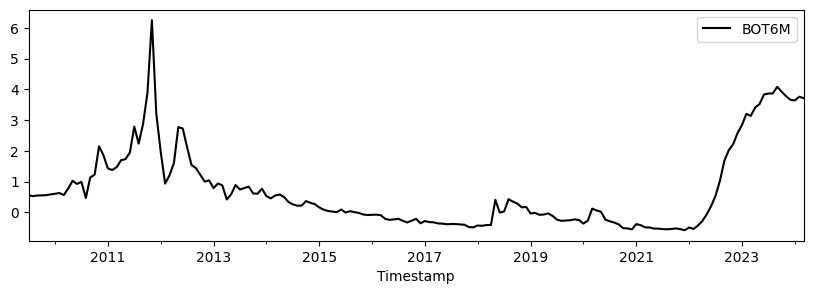

In [2]:
# import monthly italian bonds yields @6M
data = pd.read_csv("data/bot6m.csv", index_col="Timestamp", parse_dates=True)
data.plot(color='black', figsize=(10, 3))

### Calibration

In [3]:
ou = OrnsteinUhlenbeck()
delta = 1

In [5]:
res = ou.calibrate(data, delta=delta, method="mle")
print(f"> Summary MLE:\n{ou.parameters}\n{res.get_summary()}")

> Summary MLE:
{'kappa': 0.032931581349927984, 'alpha': 1.2385337326635115, 'sigma': 0.4050246436481997}
{'LogLikelihood': -392.1268062178731, 'AIC': 790.2536124357462, 'BIC': 799.7820616334676}


In [8]:
res = ou.calibrate(data, delta=delta, method="parametric_bootstrap")
print(f"> Summary Parametric-Bootstrap:\n{ou.parameters}\n{res.get_summary()}")

> Summary Parametric-Bootstrap:
{'kappa': 0.004959943238429625, 'alpha': 1.2368300352543558, 'sigma': 0.403624477391021}
{'LogLikelihood': -378.1484669037515, 'AIC': 762.296933807503, 'BIC': 771.8253830052245}


### Forecasting
Forecast the dataset using the calibration parameters obtained using Parametric-Bootstrap (lower AIC)

In [9]:
initial_value = data.iloc[-1].at['BOT6M']
last_date = data.index[-1]
forecasting_horizon = 72
forecasting_timestamp = pd.date_range(start=last_date, freq='ME', periods=forecasting_horizon + 1)

# perform simulation
realizations = ou.simulate(
    initial_value=initial_value,
    n_steps=forecasting_horizon,
    n_simulations=1000
)
realizations.index = forecasting_timestamp


In [10]:
median = realizations.median(axis=1)
median.name = 'Median'
upper = realizations.quantile(0.9, axis=1)
lower = realizations.quantile(0.1, axis=1)

predictions = pd.concat([lower, upper], axis=1)
predictions.columns = ['10%', '90%'] 

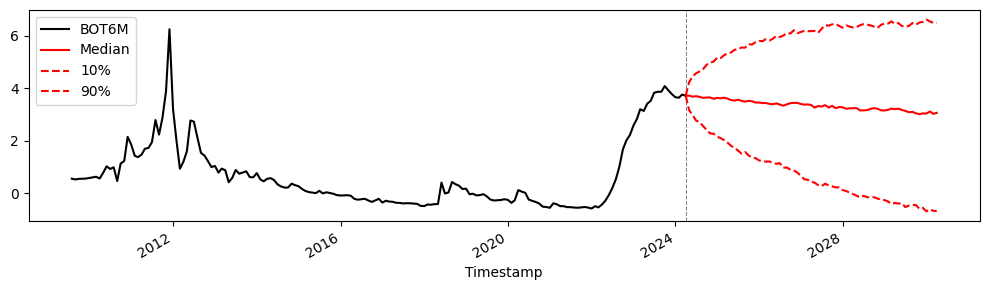

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.axvline(last_date, color='gray', linewidth=0.75, linestyle='dashed')
data.plot(ax=ax, color='black')
median.to_frame().plot(ax=ax, color='red')
predictions.plot(ax=ax, color='red', linestyle='dashed')
fig.tight_layout()